# Import Data

In [4]:
DATASETNAME = "emotion"

In [5]:
from datasets import load_dataset
dataset = load_dataset(DATASETNAME)

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
import torch
if torch.cuda.is_available():
	deviceName = "cuda"
else:
	deviceName = "cpu"
device = torch.device(deviceName)

# Preprocess Data

In [7]:
MODELNAME = "bert-base-uncased" # MODELNAME = "bert-large-uncased"

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODELNAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [9]:
datasetEncoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
datasetEncoded['train'][0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,


In [11]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(MODELNAME, num_labels=num_labels).to(device))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
datasetEncoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [13]:
datasetEncoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
datasetEncoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

# Train the model

In [14]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [15]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(datasetEncoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=8,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False)

In [16]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=datasetEncoded["train"],
                  eval_dataset=datasetEncoded["validation"])
trainer.train();

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16000
  Num Epochs = 8
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 2000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.246282,0.915500,0.912841
2,0.497700,0.157451,0.936000,0.936006
3,0.497700,0.142937,0.939500,0.940025
4,0.108600,0.146242,0.935500,0.935329
5,0.108600,0.156798,0.939000,0.938752
6,0.066800,0.170332,0.941500,0.941052
7,0.066800,0.175253,0.938500,0.938635
8,0.043800,0.182269,0.939000,0.938838


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-250
Configuration saved in results/checkpoint-250/config.json
Model weights saved in results/checkpoint-250/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bi

In [17]:
results = trainer.evaluate()
results

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


{'eval_loss': 0.1703319400548935,
 'eval_accuracy': 0.9415,
 'eval_f1': 0.9410518444214008,
 'eval_runtime': 8.5555,
 'eval_samples_per_second': 233.768,
 'eval_steps_per_second': 3.74,
 'epoch': 8.0}

In [18]:
preds_output = trainer.predict(datasetEncoded["validation"])
preds_output.metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


{'test_loss': 0.1703319400548935,
 'test_accuracy': 0.9415,
 'test_f1': 0.9410518444214008,
 'test_runtime': 8.702,
 'test_samples_per_second': 229.834,
 'test_steps_per_second': 3.677}

# Show results in a confusion matrix

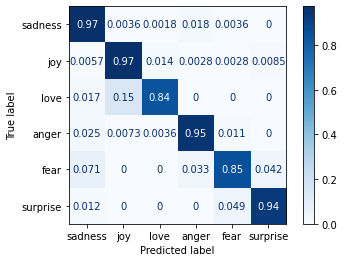

In [30]:
import numpy as np
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
def confusion_ma(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()
y_valid = np.array(datasetEncoded["validation"]["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
# plot_confusion_matrix(y_preds, y_valid, labels)
# cm = confusion_matrix(y_preds, y_valid, labels, normalize=False)
# f = sns.heatmap(cm, annot=True)
confusion_ma(y_valid, y_preds, labels)